In [2]:
# !python video_test2.py
# !python img_test.py

- No important # of reps
- Important: predict when will fail

- Now: only YOLO (front 2D view) + Design Proposal (Mech & Electr)
- Then: YOLO + MDE for analysis from side views (3D pose estimation) + Pattern using sensors
- 

1. VIZ (move)
2. PCA
2. VIZ x 2
4. Data
4. Pred

In [3]:
import os
import sys
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt

sys.path.append(os.getcwd())

def format_cols(df):
    for col in df.columns:
        if df[col].dtype != 'O':
            continue
        df[col] = df[col].apply(lambda x: eval(x) if isinstance(x, str) else x)
        df[[f'{col}_x', f'{col}_y']] = pd.DataFrame(df[col].tolist(), index=df.index)
        del df[col]
    return df


file_path = "videos/output/my_squats_vid.csv"
df = pd.read_csv(file_path)

# PREPROCESSING
df['date'] = pd.to_datetime(df['timestamp'], unit='s')
df = format_cols(df) # Originally each pair of coord comes in string. This function splits them into x and y columns
df.loc[:, (df.columns.str.contains('x')) | (df.columns.str.contains('y'))] = df.loc[:, (df.columns.str.contains('x')) | (df.columns.str.contains('y'))].replace(0.0, np.nan)
del df['timestamp'] # We don't need this anymore
del df['left_ear_x'] # non tracked, all Nans
del df['left_ear_y'] # non tracked, all Nans
del df['frame'] # We don't need this anymore

# IMPUTATION OF MISSING VALUES
imp = IterativeImputer(missing_values=np.nan, max_iter=20, random_state=0)
df.loc[:,df.columns.str.contains('x') | df.columns.str.contains('y')] = imp.fit_transform(df.loc[:,df.columns.str.contains('x') | df.columns.str.contains('y')])
df

,person,date,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,right_ear_x,right_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0,2024-11-09 21:30:02.112986803,338.098541,394.321014,299.264135,357.184395,331.826202,385.282013,302.359161,391.590118,...,157.525528,570.889832,260.874451,585.919739,285.845612,600.457275,194.329941,692.375610,196.933990,707.914307
1,0,2024-11-09 21:30:02.791515350,337.908722,404.471619,296.561680,366.013662,331.195221,396.152466,300.480927,404.935608,...,157.863235,578.310242,258.980042,589.516052,285.818176,600.775024,191.573441,696.429382,194.649139,708.592590
2,0,2024-11-09 21:30:03.314315796,336.734924,408.669373,296.508961,370.656889,329.254822,400.493652,298.806519,409.224091,...,159.389633,579.375366,259.643402,591.776733,287.707520,603.098328,190.384064,697.163147,196.698639,710.111816
3,0,2024-11-09 21:30:03.861428499,337.568420,411.765350,293.588940,373.330940,329.937561,403.838989,299.982819,412.650635,...,161.983414,580.548096,255.453400,589.469604,289.476013,606.793457,185.447189,688.661011,203.753296,710.278442
4,0,2024-11-09 21:30:04.375635386,338.633575,409.742920,292.992676,373.447148,330.415558,402.546295,300.140411,413.835632,...,164.720535,579.356201,252.723679,590.540955,289.761597,609.019958,183.797775,687.228088,205.501709,710.673706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,0,2024-11-09 21:31:59.454895258,249.793747,229.213669,247.638440,218.173676,238.035721,219.439835,207.631348,235.866028,...,171.870392,496.161285,256.902924,592.634033,274.010193,605.408203,215.644821,728.633423,205.975113,754.983826
223,0,2024-11-09 21:31:59.965015888,247.260895,221.255920,245.477448,208.672195,233.813431,211.430191,204.972260,228.650421,...,173.077744,489.157990,254.027496,589.733032,271.350372,601.274719,220.727646,725.865479,202.684830,753.763428
224,0,2024-11-09 21:32:00.479290724,242.518188,215.688034,243.388029,203.833041,229.544205,206.255417,201.451279,224.032852,...,175.442108,480.836029,244.704147,583.991577,262.046631,595.369202,220.808640,722.127197,206.589294,749.354736
225,0,2024-11-09 21:32:00.984639883,239.794205,210.914200,240.270157,198.485596,226.076965,201.293610,197.314026,218.093414,...,175.548508,476.526154,233.853546,580.130554,263.752014,589.894348,207.277298,719.843384,214.264221,747.324524


In [4]:
person_id = 0
df_p = df[df.person == person_id].reset_index(drop=True)
# PREPROCESSING FOR PERSON MOVEMENTS
x_joints = df_p.loc[:,df_p.columns.str.contains('x')].describe()
min_x = x_joints.loc["min",:].min()
max_x = x_joints.loc["max",:].max()
y_joints = df_p.loc[:,df_p.columns.str.contains('y')].describe()
min_y = y_joints.loc["min",:].min()
max_y = y_joints.loc["max",:].max()
df_p.loc[:,df_p.columns.str.contains('x')] = df_p.loc[:,df_p.columns.str.contains('x')] / max_x
df_p.loc[:,df_p.columns.str.contains('y')] = df_p.loc[:,df_p.columns.str.contains('y')] / max_y
df_p.loc[:,df_p.columns.str.contains('y')] = 1 - df_p.loc[:,df_p.columns.str.contains('y')]
df_p.head(3)

,person,date,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,right_ear_x,right_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0,2024-11-09 21:30:02.112986803,0.883946,0.477709,0.998964,0.526898,0.998851,0.489682,0.790506,0.481326,...,0.411844,0.243838,0.682046,0.223931,0.747332,0.204675,0.508068,0.082927,0.514876,0.062345
1,0,2024-11-09 21:30:02.791515350,0.883449,0.464265,0.998973,0.515203,0.998853,0.475284,0.785596,0.463650,...,0.412727,0.234010,0.677093,0.219167,0.747261,0.204254,0.500861,0.077557,0.508903,0.061447
2,0,2024-11-09 21:30:03.314315796,0.880380,0.458704,0.998973,0.509053,0.998860,0.469533,0.781218,0.457970,...,0.416718,0.232599,0.678828,0.216173,0.752200,0.201177,0.497752,0.076585,0.514261,0.059434


In [5]:
# MELT THE DATA TO LONG FORMAT FOR DATETIME VISUALIZATION
df_p_melted = df_p.melt(id_vars=[ 'person', 'date'], 
                        value_vars=[col for col in df_p.columns if '_x' in col or '_y' in col], 
                        var_name='body_part', value_name='coordinate')

df_p_melted['axis'] = df_p_melted['body_part'].apply(lambda x: 'x' if '_x' in x else 'y')
df_p_melted['body_part'] = df_p_melted['body_part'].apply(lambda x: x.replace('_x', '').replace('_y', ''))

df_p_wide = df_p_melted.pivot_table(index=['person', 'date', 'body_part'], 
                                    columns='axis', values='coordinate').reset_index()

df_p_wide['body_part'] = df_p_wide['body_part'].replace({
    'left_elbow': 'elbow',
    'right_elbow': 'elbow',
    'left_knee': 'knee',
    'right_knee': 'knee',
    'left_shoulder': 'shoulder',
    'right_shoulder': 'shoulder',
    'left_hip': 'hip',
    'right_hip': 'hip',
    'left_wrist': 'wrist',
    'right_wrist': 'wrist',
    'left_ankle': 'ankle',
    'right_ankle': 'ankle',
    'left_eye': 'eye',
    'right_eye': 'eye',
    'left_ear': 'ear',
    'right_ear': 'ear',
    'nose': 'nose',
    'left_eye': 'eye',
    'right_eye': 'eye',

})

fig = px.scatter(df_p_wide, x="x", y="y",color="body_part", animation_frame="date", range_x=[0, 1], range_y=[0, 1], width=800, height=800)
fig.show()

In [6]:
fig = px.scatter(df_p_wide, x="x", y="y",color="body_part", hover_data="date", range_x=[0, 1], range_y=[0, 1], width=800, height=800)
fig.show()


In [7]:
# PCA
X = df_p.loc[:,df_p.columns.str.contains('x') | df_p.columns.str.contains('y')]
X.corr().style.background_gradient(cmap='coolwarm')

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
nose_x,1.000000,-0.736883,-0.560552,-0.731847,-0.999368,-0.735684,0.995586,-0.727064,0.821531,-0.712976,0.980822,-0.721832,0.885257,-0.737942,0.890060,-0.724735,0.807015,-0.541014,0.813223,-0.344448,-0.625763,-0.675811,-0.555092,-0.674245,0.589519,-0.639568,0.675019,-0.693538,-0.333487,0.105841,0.362376,0.110353
nose_y,-0.736883,1.000000,-0.074353,0.998807,0.742669,0.999977,-0.762147,0.999549,-0.275746,0.998645,-0.767260,0.998939,-0.836927,0.993520,-0.905424,0.997178,-0.622136,0.765166,-0.774545,0.716522,0.949555,0.992739,0.904567,0.992913,-0.808788,0.895315,-0.931314,0.903550,0.343849,0.224837,-0.414636,0.196035
left_eye_x,-0.560552,-0.074353,1.000000,-0.066828,0.552700,-0.074725,-0.529295,-0.082238,-0.818492,-0.100127,-0.507500,-0.087214,-0.438462,-0.093784,-0.319524,-0.109276,-0.621877,-0.285319,-0.420057,-0.535741,-0.109863,-0.157058,-0.138509,-0.159111,0.010934,-0.135459,0.089230,-0.049380,0.036829,-0.452281,0.026846,-0.445656
left_eye_y,-0.731847,0.998807,-0.066828,1.000000,0.737465,0.999016,-0.758582,0.999445,-0.270110,0.998926,-0.763014,0.999386,-0.847036,0.989011,-0.909581,0.994746,-0.638791,0.736312,-0.785935,0.694968,0.959261,0.990042,0.916910,0.990388,-0.811252,0.895185,-0.935845,0.906920,0.347526,0.219034,-0.419160,0.200314
right_eye_x,-0.999368,0.742669,0.552700,0.737465,1.000000,0.741369,-0.997050,0.732447,-0.815640,0.718753,-0.978937,0.727260,-0.886881,0.744559,-0.890471,0.731381,-0.811148,0.549828,-0.817605,0.355563,0.631119,0.682135,0.560903,0.680548,-0.592639,0.650629,-0.678338,0.703207,0.329196,-0.085813,-0.372170,-0.091746
right_eye_y,-0.735684,0.999977,-0.074725,0.999016,0.741369,1.000000,-0.761033,0.999711,-0.274169,0.998800,-0.766623,0.999164,-0.837236,0.993033,-0.905844,0.996945,-0.622172,0.762523,-0.774850,0.714548,0.950570,0.992636,0.905664,0.992842,-0.808268,0.894924,-0.931779,0.903589,0.345959,0.222339,-0.414530,0.194522
right_ear_x,0.995586,-0.762147,-0.529295,-0.758582,-0.997050,-0.761033,1.000000,-0.752964,0.802159,-0.740292,0.974280,-0.748271,0.899700,-0.763401,0.896447,-0.751418,0.823448,-0.547215,0.835686,-0.369832,-0.663012,-0.700711,-0.597847,-0.699544,0.618015,-0.671360,0.712021,-0.727282,-0.327292,0.087000,0.420463,0.069695
right_ear_y,-0.727064,0.999549,-0.082238,0.999445,0.732447,0.999711,-0.752964,1.000000,-0.262730,0.999369,-0.759420,0.999746,-0.835606,0.991451,-0.904217,0.996178,-0.619811,0.753210,-0.774478,0.709575,0.955373,0.992571,0.911735,0.992897,-0.809152,0.893369,-0.934514,0.902907,0.347889,0.218075,-0.414499,0.194460
left_shoulder_x,0.821531,-0.275746,-0.818492,-0.270110,-0.815640,-0.274169,0.802159,-0.262730,1.000000,-0.247814,0.755362,-0.255821,0.626530,-0.287862,0.531250,-0.262525,0.656727,-0.180255,0.532717,0.025137,-0.143028,-0.198846,-0.103972,-0.194864,0.292608,-0.262711,0.266973,-0.319462,-0.131412,0.302829,0.285513,0.263670
left_shoulder_y,-0.712976,0.998645,-0.100127,0.998926,0.718753,0.998800,-0.740292,0.999369,-0.247814,1.000000,-0.743914,0.999510,-0.829772,0.992115,-0.895496,0.996317,-0.613232,0.752772,-0.769862,0.715360,0.957699,0.993850,0.917423,0.994017,-0.816657,0.897776,-0.938035,0.904557,0.335479,0.231543,-0.421742,0.209475


cumsum_exp_var:  [0.90192351 0.95656219 0.98017819] ...
eigens:  [0.21765216 0.0131854  0.00569901] ...


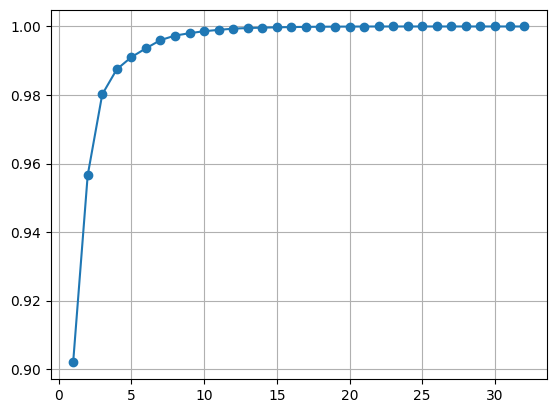

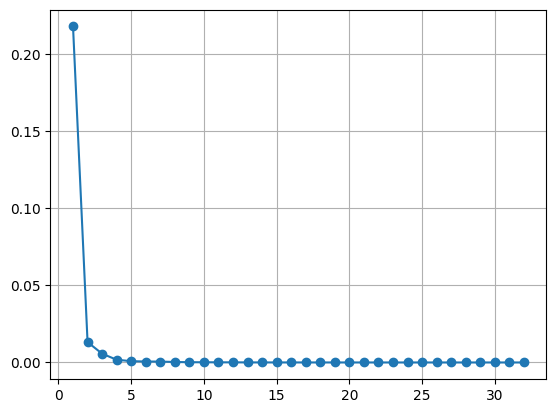

In [8]:
# Apply PCA
pca = PCA(n_components=None)
X_pca = pca.fit(X)
exp_var = X_pca.explained_variance_ratio_
eigens = pca.explained_variance_
n_components = np.arange(1, len(exp_var)+1)
cumsum_exp_var = np.cumsum(exp_var)
print("cumsum_exp_var: ", cumsum_exp_var[:3],"...")
print("eigens: ", eigens[:3],"...")
plt.plot(n_components, cumsum_exp_var, 'o-')
plt.grid()
plt.show()
plt.plot(n_components, eigens, 'o-')
plt.grid()
plt.show()


cumsum_exp_var:  [0.90192351 0.95656219 0.98017819] ...
eigens:  [0.21765216 0.0131854  0.00569901] ...


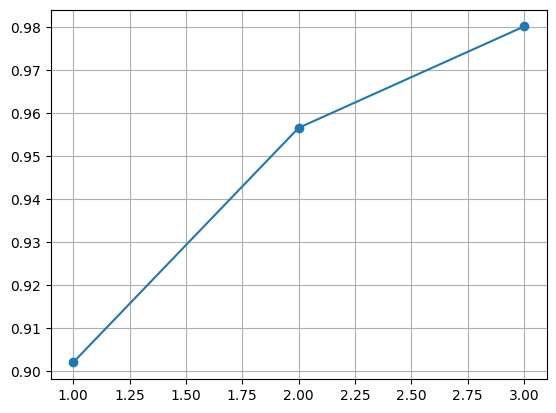

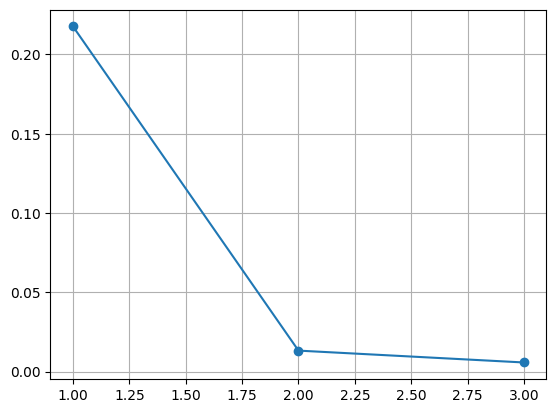

In [9]:
# I Take only 3 values
pca = PCA(n_components=3)
X_pca = pca.fit(X)
exp_var = X_pca.explained_variance_ratio_
eigens = pca.explained_variance_
n_components = np.arange(1, len(exp_var)+1)
cumsum_exp_var = np.cumsum(exp_var)
print("cumsum_exp_var: ", cumsum_exp_var[:3],"...")
print("eigens: ", eigens[:3],"...")
plt.plot(n_components, cumsum_exp_var, 'o-')
plt.grid()
plt.show()
plt.plot(n_components, eigens, 'o-')
plt.grid()
plt.show()

In [10]:
pca_j_df = pd.DataFrame(pca.transform(X), columns=[f'joint_pca_{i}' for i in range(1, 4)])
df_p = pd.concat([df_p[["person",	"date"]], pca_j_df], axis=1)
df_p

,person,date,joint_pca_1,joint_pca_2,joint_pca_3
0,0,2024-11-09 21:30:02.112986803,-0.235680,0.113867,0.011353
1,0,2024-11-09 21:30:02.791515350,-0.276273,0.086665,0.034584
2,0,2024-11-09 21:30:03.314315796,-0.287963,0.084516,0.041749
3,0,2024-11-09 21:30:03.861428499,-0.292937,0.073050,0.048329
4,0,2024-11-09 21:30:04.375635386,-0.286871,0.072585,0.056544
...,...,...,...,...,...
222,0,2024-11-09 21:31:59.454895258,0.506149,-0.308616,-0.125216
223,0,2024-11-09 21:31:59.965015888,0.562365,-0.351685,-0.102227
224,0,2024-11-09 21:32:00.479290724,0.625709,-0.395185,-0.098335
225,0,2024-11-09 21:32:00.984639883,0.674638,-0.441243,-0.085380


In [11]:
range_jp1 = df_p.joint_pca_1.min(), df_p.joint_pca_1.max()
range_jp2 = df_p.joint_pca_2.min(), df_p.joint_pca_2.max()

# Create the animated scatter plot with lines and markers
fig = px.scatter(df_p, 
                 x="joint_pca_2", 
                 y="joint_pca_1", 
                 color="joint_pca_3", 
                 hover_data="date" ,
                 range_x=range_jp2, 
                 range_y=range_jp1, 
                 width=800, 
                 height=800)

# Add traces by connecting points over time
fig.update_traces(marker=dict(size=10), mode='lines+markers') 

fig.show()

fig = px.scatter(df_p, x="joint_pca_2", y="joint_pca_1", color="joint_pca_3", animation_frame="date", range_x=range_jp2, range_y=range_jp1, width=800, height=800)
fig.update_traces(marker=dict(size=10))  # Increase the size of the points
fig.show()